<a href="https://colab.research.google.com/github/IAmSuyogJadhav/midas-iiitd-tasks/blob/master/CV_Problem/cv_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab Stuff
Some setup needed to run the notebook in Google Colab environment.

Mount the Google Drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


For using tensorboard in Google Colab

In [2]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

--2019-04-07 05:25:52--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.72.250.2, 35.173.3.255, 52.55.191.55, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.72.250.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14977695 (14M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  14.28M  7.07MB/s    in 2.0s    

2019-04-07 05:25:55 (7.07 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [14977695/14977695]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


Setup TensorBoard and get public URL

In [3]:
LOG_DIR = '/tmp/log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)

# Needed for Google Colab
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

https://f2e2e67a.ngrok.io


# Imports
Import necessary packages


In [4]:
from keras.models import Sequential, Model
from keras.layers import *
from keras.utils import to_categorical
import keras
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


# Load the data
Load the data from the data folder and see their format.

In [0]:
DATA_PATH = '/gdrive/My Drive/Vision_task_dataset_public/'

In [0]:
train = pickle.load(open(DATA_PATH + 'train_image.pkl', 'rb'))
test = pickle.load(open(DATA_PATH + 'test_image.pkl', 'rb'))

labels = pickle.load(open(DATA_PATH + 'train_label.pkl', 'rb'))
sample_sub = pd.read_csv(DATA_PATH + 'hitkul(sample_submission).csv')

In [8]:
print(type(train), type(test), type(labels))

<class 'list'> <class 'list'> <class 'list'>


In [9]:
print(len(train), len(test), len(labels))

8000 2000 8000


In [10]:
len(train[0])

784

In [11]:
set(labels)

{0, 2, 3, 6}

Looks like we have a list of flattened grayscale images, 8000 in train and 2000 in the test. The label for each of them is one of 0, 2, 3, and 6.

---
Let's first convert the data into numpy arrays.

In [0]:
train = np.array(train)
test = np.array(test)
labels = np.array(labels)

In [0]:
train = train.reshape((len(train), 28, 28))
test = test.reshape((len(test), 28, 28))

# Analyze the dataset

See a random image

0


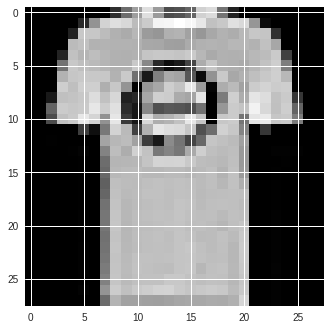

In [62]:
idx = 7
print(labels[idx])
plt.imshow(train[idx], cmap='Greys_r')

Looks like fashion MNIST.

Classes distribution

In [74]:
pd.Series(labels).value_counts()

3    2000
6    2000
2    2000
0    2000
dtype: int64

From above, we can see that the classes are perfectly balanced. So, we don't need to worry about class imbalance.

# Preprocessing

We will convert the labels as following for the sake of convenience.

Original | New
--|--
0 |  0
2 |  1
3 |  2
6 |  3

In [0]:
def convert_labels(labels, reverse=False):
  """
  Convert labels between original and new formats.
  If reverse is True, converts new labels to original labels.
  If reverse is False, converts original labels to new labels.
  """
  
  if not reverse:
    mapping = {0:0, 2:1, 3:2, 6:3}
  else:
    mapping = {0:0, 1:2, 2:3, 3:6}
    
  converted = np.array(list(map(lambda x: mapping[x], labels)))
  return converted

In [0]:
labels = convert_labels(labels)

Normalize image pixel values

In [0]:
train_norm = train / 255
test_norm = test / 255

# Model

## Wide Residual Network
&lt;This produced the best result>

Implementation of [Wide Residual Networks (Zagoruyko  et. al. 2016)](https://arxiv.org/abs/1605.07146)

In [0]:
def main_block(x, filters, n, strides, dropout):
	# Normal part
	x_res = Conv2D(filters, (3,3), strides=strides, padding="same")(x) # , kernel_regularizer=keras.regularizers.l2(5e-4)
	x_res = BatchNormalization()(x_res)
	x_res = Activation('relu')(x_res)
	x_res = Conv2D(filters, (3,3), padding="same")(x_res)
	# Alternative branch
	x = Conv2D(filters, (1,1), strides=strides)(x)
	# Merge Branches
	x = Add()([x_res, x])

	for i in range(n-1):
		# Residual conection
		x_res = BatchNormalization()(x)
		x_res = Activation('relu')(x_res)
		x_res = Conv2D(filters, (3,3), padding="same")(x_res)
		# Apply dropout if given
		if dropout: x_res = Dropout(dropout)(x)
		# Second part
		x_res = BatchNormalization()(x_res)
		x_res = Activation('relu')(x_res)
		x_res = Conv2D(filters, (3,3), padding="same")(x_res)
		# Merge branches
		x = Add()([x, x_res])

	# Inter block part
	x = BatchNormalization()(x)
	x = Activation('relu')(x)
	return x

def build_model(input_dims, output_dim, n, k, act= "relu", dropout=None):
	""" Builds the model. Params:
			- n: number of layers. WRNs are of the form WRN-N-K
				 It must satisfy that (N-4)%6 = 0
			- k: Widening factor. WRNs are of the form WRN-N-K
				 It must satisfy that K%2 = 0
			- input_dims: input dimensions for the model
			- output_dim: output dimensions for the model
			- dropout: dropout rate - default=0 (not recomended >0.3)
			- act: activation function - default=relu. Build your custom
				   one with keras.backend (ex: swish, e-swish)
	"""
	# Ensure n & k are correct
	assert (n-4)%6 == 0
	assert k%2 == 0
	n = (n-4)//6 
	# This returns a tensor input to the model
	inputs = Input(shape=(input_dims))

	# Head of the model
	x = Conv2D(16, (3,3), padding="same")(inputs)
	x = BatchNormalization()(x)
	x = Activation('relu')(x)

	# 3 Blocks (normal-residual)
	x = main_block(x, 8*k, n, (1,1), dropout) # 0
	x = main_block(x, 16*k, n, (2,2), dropout) # 1
# 	x = main_block(x, 32*k, n, (2,2), dropout) # 2
			
	# Final part of the model
	x = AveragePooling2D((8,8))(x)
	x = Flatten()(x)
	outputs = Dense(output_dim, activation='softmax')(x)  #, activation="softmax")(x)

	model = Model(inputs=inputs, outputs=outputs)
	return model

In [97]:
model = build_model((28, 28, 1), 4, 10, 4)
opt = 'adam'
epochs = 25
model_name = 'WRN'
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_93 (Conv2D)              (None, 28, 28, 16)   160         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_66 (BatchNo (None, 28, 28, 16)   64          conv2d_93[0][0]                  
__________________________________________________________________________________________________
activation_66 (Activation)      (None, 28, 28, 16)   0           batch_normalization_66[0][0]     
__________________________________________________________________________________________________
conv2d_94 

## Mini VGG
&lt;Didn't work very well>

In [30]:
model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(16, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(4))
model.add(Activation('softmax'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
activation_9 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_10 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 28, 28, 32)        128       
___________________________

In [0]:
lr = 1e-2
opt = keras.optimizers.SGD(lr=lr, momentum=0.9, decay=lr/epochs)
epochs = 25
model_name = 'mini_VGG'

## Small Residual Network
&lt;Didn't work very well>

In [0]:
def residual_block(inp, filters, kernel_size):
  x = Conv2D(filters, kernel_size, padding='same')(inp)
  x = Conv2D(filters, kernel_size, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  inp_res = Conv2D(filters, (1, 1), padding='same')(inp)
  x = Add()([x, inp_res])
  
  return x

In [18]:
# model = Sequential()

inp = Input((28, 28, 1))

x = residual_block(inp, 8, (3, 3))
x = MaxPool2D((2, 2))(x)

x = residual_block(x, 16, (3, 3))
x = MaxPool2D((2, 2))(x)

x = residual_block(x, 32, (3, 3))
x = MaxPool2D((2, 2))(x)

# x = Flatten()(x)
x = GlobalAveragePooling2D()(x)
x = Activation('relu')(x)
# model.add(Dense(30, activation='relu'))
out = Dense(4, activation='softmax')(x)

model = Model(inp, out)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 8)    80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 28, 28, 8)    584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 28, 28, 8)    32          conv2d_2[0][0]                   
_____________________________________

In [0]:
model_name = 'custom_residual'
opt = 'adam'
epochs = 20

## Compile the model, set callbacks and fit the model

In [0]:
model.compile(opt, 'categorical_crossentropy', metrics=['acc'])

Tensorboard Callback

In [0]:
tboard = keras.callbacks.TensorBoard(
    log_dir=LOG_DIR,
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=False,
    write_images=False,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None, 
    embeddings_data=None, 
    update_freq='batch'
)


Model Checkpointing Callback

In [0]:
model_name = "Model." + model_name + ".val-acc={val_acc:.2f}.val-loss={val_loss:.2f}.h5"
ckpt = keras.callbacks.ModelCheckpoint(
                  model_name,
                  monitor='val_loss',
                  verbose=0,
                  save_best_only=True,
                  save_weights_only=False,
                  mode='auto',
                  period=1
)

Convert labels to one-hot encoding and train the model.

In [0]:
# Clean Tensorboard logging directory before training if needed
!rm -r /tmp/log

In [0]:
labels_one_hot = to_categorical(labels)

model.fit(
    train_norm[..., None],
    labels_one_hot,
    validation_split=0.2,
    shuffle=True,
    callbacks=[ckpt, tboard],
    epochs = epochs,
    batch_size=32
)

# Predict for the test data and generate submission

## Ensemble best 3 models

Load the best 3 models and ensemble their predictions

In [0]:
model1 = keras.models.load_model('Model.WRN.val-acc=0.87.val-loss=0.33.h5')
model2 = keras.models.load_model('Model.WRN.val-acc=0.82.val-loss=0.42.h5')
model3 = keras.models.load_model('Model.WRN.val-acc=0.76.val-loss=0.57.h5')

In [0]:
pred1 = np.argmax(model1.predict(train_norm[..., None]), axis=1)
pred2 = np.argmax(model2.predict(train_norm[..., None]), axis=1)
pred3 = np.argmax(model3.predict(train_norm[..., None]), axis=1)
preds = np.hstack([pred1[:, None], pred2[:, None], pred3[:, None]])

Fit a logistic regression model

In [161]:
reg = LogisticRegression(solver='lbfgs').fit(preds, labels)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [162]:
reg.score(preds, labels)

0.858

So, our ensemble achieves 85.8 % on the train data.

## Predict for the test data

In [0]:
pred1 = np.argmax(model1.predict(test_norm[..., None]), axis=1)
pred2 = np.argmax(model2.predict(test_norm[..., None]), axis=1)
pred3 = np.argmax(model3.predict(test_norm[..., None]), axis=1)
preds = np.hstack([pred1[:, None], pred2[:, None], pred3[:, None]])

In [0]:
final_pred = reg.predict(preds)

Convert labels back to the original format

In [0]:
final_pred = convert_labels(final_pred, reverse=True)

Create the predictions `CSV` according to the sample submission format given.

In [175]:
sample_sub

,image_index,class
0,0,2
1,1,3
2,2,0
3,3,6


In [0]:
pred = pd.DataFrame(np.hstack([np.arange(len(test))[:, None], final_pred[:, None]]), columns=sample_sub.columns)

In [188]:
pred['class'].value_counts()

0    534
2    514
6    510
3    442
Name: class, dtype: int64

In [189]:
pred.head()

,image_index,class
0,0,0
1,1,6
2,2,0
3,3,0
4,4,0


Everything looks fine and according to the sample submission format. Dump the predictions into a `CSV` file.

In [0]:
pred.to_csv('pred.csv', index=False)